# About the results
The Mean Squared Error (MSE) value of 1724670.74 represents the average squared difference between predicted and actual values. A lower MSE generally indicates better model performance. Therefore, this value suggests reasonable model performance.

The R-squared (R2) value of 0.8462 signifies the proportion of variance explained by the model. An R2 value closer to 1 indicates a better fit. In this case, R2 suggests a good fit, explaining approximately 84.62% of the variance.

Regarding feature importance:

'2020_Torneos ganados' and '2020_Finales' are the most important features, with values of 1233.69 and 1250.23, respectively. It's likely that '2020_Torneos ganados' holds more significance, but in padel, the ranking is the sum of points from the last 365 days. Thus, this data would be more accurate if it only considered results from the last 365 days (from January 1 to December 31 of 2020). The fact that the top-ranked male player has only participated in 1 tournament and reached 1 final suggests a potential decline from his previous performance.

'2020_Rendimiento' is also one of the most important features, with a value of 957.83. Since only a small percentage of players win tournaments, it's crucial to have a feature that can relate to all players. Better performance directly translates to improved results in tournaments.

'partidosganados' has the lowest importance but still contributes positively with a value of 15.22. These values indicate the relative importance of each feature in predicting 'puntuacion' points, with the 2020 performance metrics playing a substantial role.

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
import psycopg2
import pandas as pd

# Connect to the PostgreSQL database
connection = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="daredatachallenge",
    user="admin",
    password="admin",
)

print("Connected to the database!")


# Create a cursor object to execute SQL queries
cursor = connection.cursor()

Connected to the database!


In [3]:
def query_database(connection, query):
    try:
        # Execute the SQL query
        df = pd.read_sql(query, connection)
        return df
    except Exception as error:
        print(f"Error: {error}")

sql_query = "SELECT * FROM padel_players;"

# Query the database and store the results in a DataFrame
df = query_database(connection, sql_query)
df.head()

C:\Users\Cisco\AppData\Local\Temp\ipykernel_60400\347174169.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,player_id,nombre,ranking,puntuacion,companero,posicion,lugarnacimiento,fechanacimiento,altura,residencia,...,2014_Rendimiento,2014_Torneos ganados,2014_Finales,2013_PartidosJugados,2013_PartidosGanados,2013_PartidosPerdidos,2013_Rendimiento,2013_Torneos ganados,2013_Finales,circuito
0,1,Francisco Navarro Compï¿½n,1,12010,Pablo Lima,Revï¿½s,Sevilla,1989-02-10,1.81,Madrid,...,0.760000,2,1,50,32,18,0.640000,0,0,Masculino
1,2,Juan Lebrï¿½n Chincoa,2,11330,Alejandro Galï¿½n Romo,Revï¿½s,Puerto de Sta. Marï¿½a,1995-01-30,1.84,Madrid,...,0.545455,0,0,15,5,10,0.333333,0,0,Masculino
2,3,Alejandro Galï¿½n Romo,3,11100,Juan Lebrï¿½n Chincoa,Revï¿½s,Madrid,1996-05-15,1.86,Madrid,...,0.500000,0,0,0,0,0,0.000000,0,0,Masculino
3,4,Pablo Lima,4,10860,Francisco Navarro Compï¿½n,Drive,Porto Alegre - Bra,1986-10-11,1.80,Bilbao,...,0.807692,2,5,82,68,14,0.829268,4,10,Masculino
4,5,Carlos Daniel Gutiï¿½rrez,5,9020,Franco Stupaczuk,Drive,San Luis - Argentina,1984-06-15,1.77,Madrid,...,0.759259,1,4,69,53,16,0.768116,2,1,Masculino


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 64 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   player_id              100 non-null    int64  
 1   nombre                 100 non-null    object 
 2   ranking                100 non-null    int64  
 3   puntuacion             100 non-null    int64  
 4   companero              100 non-null    object 
 5   posicion               100 non-null    object 
 6   lugarnacimiento        100 non-null    object 
 7   fechanacimiento        100 non-null    object 
 8   altura                 100 non-null    float64
 9   residencia             100 non-null    object 
 10  partidosjugados        100 non-null    int64  
 11  partidosganados        100 non-null    int64  
 12  partidosperdidos       100 non-null    int64  
 13  rendimiento            100 non-null    float64
 14  racha                  100 non-null    int64  
 15  2020_Pa

In [5]:
# Feature engineering

# Average win percentage over the years (if we didnt have the totals already)
#df['average_win_percentage'] = (df.filter(like='PartidosGanados').sum(axis=1) / df.filter(like='PartidosJugados').sum(axis=1)).fillna(0)
#df.drop('average_win_percentage', axis=1, inplace=True)

# Win/loss ratio
df['win_loss_ratio'] = df['partidosganados'] / df['partidosjugados']

# Binary feature indicating if a player has won a tournament in 2020 
# (could have done from 2013 but wanted to know how restricted champions players are in a single year)
df['won_tournament_2020'] = (df['2020_Torneos ganados'] > 0).astype(int)

# Extract the birth year
df['birth_year'] = pd.to_datetime(df['fechanacimiento']).dt.year

# Calculate the age
df['age'] = 2020 - df['birth_year']

import pandas as pd

# Create height category
bin_edges = [1.60,1.70, 1.80, 1.90, 2.00]
bin_labels = ['short', 'average', 'tall', 'very tall']

df['height_cat'] = pd.cut(df['altura'], bins=bin_edges, labels=bin_labels, include_lowest=True)

columns_to_drop = ['fechanacimiento', 'birth_year']
df = df.drop(columns=columns_to_drop)


In [6]:
# Select a subset of columns
selected_columns1 = ["win_loss_ratio", "won_tournament_2020" ,"age","nombre","height_cat"]

print(df[selected_columns1])

# Calculate the number of players who won a tournament in 2020 for each circuito
number_of_players_per_circuito = df.groupby('circuito')['won_tournament_2020'].sum()

# Print the number of players for each circuito
print("\n",number_of_players_per_circuito)

    win_loss_ratio  won_tournament_2020  age                      nombre  \
0         0.754300                    1   31  Francisco Navarro Compï¿½n   
1         0.632450                    1   25       Juan Lebrï¿½n Chincoa   
2         0.689895                    1   24      Alejandro Galï¿½n Romo   
3         0.855792                    1   34                  Pablo Lima   
4         0.780374                    1   36   Carlos Daniel Gutiï¿½rrez   
..             ...                  ...  ...                         ...   
95        0.383929                    0   32         Sara Pujals Pï¿½rez   
96        0.413462                    0   24     Elena Ramï¿½rez Gï¿½mez   
97        0.410256                    0   35      ï¿½ngela Caro Cantï¿½n   
98        0.476562                    0   37                 Celeste Paz   
99        0.378378                    0   25              Sara Ruiz Soto   

   height_cat  
0        tall  
1        tall  
2        tall  
3     average  
4     a

In [7]:

selected_columns = ["puntuacion", "altura", "age","partidosjugados",
                    "partidosganados", "partidosperdidos", "rendimiento"]  

# Generate summary statistics for specific columns
subset_summary = df[selected_columns].describe()

# Print the summary
print(subset_summary)


         puntuacion      altura        age  partidosjugados  partidosganados  \
count    100.000000  100.000000  100.00000       100.000000       100.000000   
mean    3228.640000    1.737200   29.89000       211.090000       126.520000   
std     3074.141587    0.082695    7.02218        87.962928        75.109412   
min      784.000000    1.580000   16.00000        54.000000        26.000000   
25%     1205.000000    1.670000   24.00000       134.250000        60.750000   
50%     1845.000000    1.735000   29.00000       223.000000       118.000000   
75%     4308.750000    1.800000   35.00000       263.250000       164.250000   
max    12490.000000    1.970000   45.00000       428.000000       369.000000   

       partidosperdidos  rendimiento  
count        100.000000   100.000000  
mean          84.570000     0.565583  
std           28.974825     0.118425  
min           28.000000     0.371212  
25%           60.000000     0.475126  
50%           83.500000     0.545098  
75%   

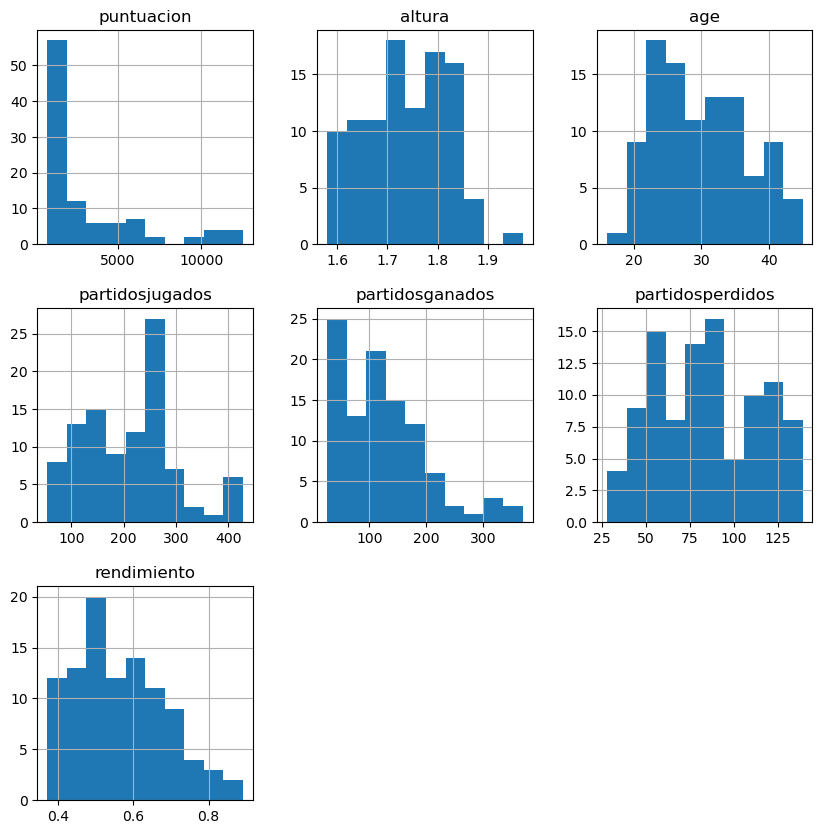

In [8]:
# Analyze the distribution of variables
df[selected_columns].hist(figsize=(10, 10))
plt.show()

In [9]:
# Normaly the ranking ins only related to the lattest year so i am going to remove irrelevant columns

columns_to_drop2 = ['2019_PartidosJugados', '2019_PartidosGanados', '2019_PartidosPerdidos',
       '2019_Rendimiento', '2019_Torneos ganados', '2019_Finales',
       '2018_PartidosJugados', '2018_PartidosGanados', '2018_PartidosPerdidos',
       '2018_Rendimiento', '2018_Torneos ganados', '2018_Finales',
       '2017_PartidosJugados', '2017_PartidosGanados', '2017_PartidosPerdidos',
       '2017_Rendimiento', '2017_Torneos ganados', '2017_Finales',
       '2016_PartidosJugados', '2016_PartidosGanados', '2016_PartidosPerdidos',
       '2016_Rendimiento', '2016_Torneos ganados', '2016_Finales',
       '2015_PartidosJugados', '2015_PartidosGanados', '2015_PartidosPerdidos',
       '2015_Rendimiento', '2015_Torneos ganados', '2015_Finales',
       '2014_PartidosJugados', '2014_PartidosGanados', '2014_PartidosPerdidos',
       '2014_Rendimiento', '2014_Torneos ganados', '2014_Finales',
       '2013_PartidosJugados', '2013_PartidosGanados', '2013_PartidosPerdidos',
       '2013_Rendimiento', '2013_Torneos ganados', '2013_Finales']

df = df.drop(columns=columns_to_drop2)


In [10]:
# Calculate the correlation matrix
df.corr()


C:\Users\Cisco\AppData\Local\Temp\ipykernel_60400\2128991674.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,player_id,ranking,puntuacion,altura,partidosjugados,partidosganados,partidosperdidos,rendimiento,racha,2020_PartidosJugados,2020_PartidosGanados,2020_PartidosPerdidos,2020_Rendimiento,2020_Torneos ganados,2020_Finales,win_loss_ratio,won_tournament_2020,age
player_id,1.000000,0.497376,-0.482906,-0.620935,-0.756109,-0.688002,-0.511964,-0.548539,-0.391861,-0.224302,-0.264587,0.134170,-0.164470,-0.245531,-0.257180,-0.548539,-0.244857,-0.105585
ranking,0.497376,1.000000,-0.819191,-0.074042,-0.490305,-0.607916,0.087370,-0.726700,-0.454789,-0.681513,-0.727501,0.114548,-0.673404,-0.508940,-0.634870,-0.726700,-0.624462,-0.098140
puntuacion,-0.482906,-0.819191,1.000000,0.132088,0.563474,0.687077,-0.070443,0.738098,0.564780,0.710614,0.790595,-0.242299,0.676439,0.716854,0.714909,0.738098,0.796573,0.094451
altura,-0.620935,-0.074042,0.132088,1.000000,0.466583,0.356484,0.492383,0.198603,0.185591,-0.040532,-0.007244,-0.131371,-0.035347,0.105935,-0.026060,0.198603,0.054226,0.021903
partidosjugados,-0.756109,-0.490305,0.563474,0.466583,1.000000,0.948967,0.575898,0.691472,0.558895,0.442728,0.427185,0.099803,0.377520,0.287191,0.358725,0.691472,0.404692,0.512939
partidosganados,-0.688002,-0.607916,0.687077,0.356484,0.948967,1.000000,0.288683,0.854780,0.715843,0.561092,0.568615,0.022071,0.500897,0.366404,0.489711,0.854780,0.550425,0.461522
partidosperdidos,-0.511964,0.087370,-0.070443,0.492383,0.575898,0.288683,1.000000,-0.116588,-0.158914,-0.110429,-0.177114,0.245774,-0.152350,-0.077940,-0.180413,-0.116588,-0.198248,0.360830
rendimiento,-0.548539,-0.726700,0.738098,0.198603,0.691472,0.854780,-0.116588,1.000000,0.702112,0.634948,0.693712,-0.167783,0.595742,0.439353,0.602350,1.000000,0.638834,0.256285
racha,-0.391861,-0.454789,0.564780,0.185591,0.558895,0.715843,-0.158914,0.702112,1.000000,0.501551,0.540798,-0.105022,0.432029,0.403809,0.551823,0.702112,0.622765,0.231413
2020_PartidosJugados,-0.224302,-0.681513,0.710614,-0.040532,0.442728,0.561092,-0.110429,0.634948,0.501551,1.000000,0.967078,0.217051,0.936525,0.663695,0.780418,0.634948,0.757332,0.131162


In [11]:
df.head()


,player_id,nombre,ranking,puntuacion,companero,posicion,lugarnacimiento,altura,residencia,partidosjugados,...,2020_PartidosGanados,2020_PartidosPerdidos,2020_Rendimiento,2020_Torneos ganados,2020_Finales,circuito,win_loss_ratio,won_tournament_2020,age,height_cat
0,1,Francisco Navarro Compï¿½n,1,12010,Pablo Lima,Revï¿½s,Sevilla,1.81,Madrid,407,...,17,6,0.73913,1,1,Masculino,0.754300,1,31,tall
1,2,Juan Lebrï¿½n Chincoa,2,11330,Alejandro Galï¿½n Romo,Revï¿½s,Puerto de Sta. Marï¿½a,1.84,Madrid,302,...,29,3,0.90625,5,1,Masculino,0.632450,1,25,tall
2,3,Alejandro Galï¿½n Romo,3,11100,Juan Lebrï¿½n Chincoa,Revï¿½s,Madrid,1.86,Madrid,287,...,29,3,0.90625,5,1,Masculino,0.689895,1,24,tall
3,4,Pablo Lima,4,10860,Francisco Navarro Compï¿½n,Drive,Porto Alegre - Bra,1.80,Bilbao,423,...,17,6,0.73913,1,1,Masculino,0.855792,1,34,average
4,5,Carlos Daniel Gutiï¿½rrez,5,9020,Franco Stupaczuk,Drive,San Luis - Argentina,1.77,Madrid,428,...,18,7,0.72000,1,1,Masculino,0.780374,1,36,average


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Feature and target
X = df[['2020_Rendimiento', '2020_Torneos ganados', '2020_Finales','partidosganados']]
y = df['puntuacion']

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 1724670.7385581278
R-squared: 0.8462457625804596


In [13]:

coefficients = model.coef_
feature_names = ['2020_Rendimiento', '2020_Torneos ganados', '2020_Finales', 'partidosganados']

for feature, coefficient in zip(feature_names, coefficients):
    print(f'{feature}: {coefficient}')

2020_Rendimiento: 957.8325756730119
2020_Torneos ganados: 1233.6920033777537
2020_Finales: 1250.228951068752
partidosganados: 15.221039453964522
